In [ ]:
# initialisations
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
from scipy import stats
from sklearn.preprocessing import StandardScaler, LabelEncoder,OneHotEncoder
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import *
pd.set_option('display.max_columns',None)
warnings.filterwarnings('ignore')

In [ ]:
sns.set(
    palette="Paired",
    #style='whitegrid',
    color_codes=True,
    rc={"figure.figsize": (12,8)},
)

In [ ]:
url='https://drive.google.com/file/d/1Fsl9G_C7ZzRn0VpfpF8CjuXkdC18Y6Vf/view?usp=sharing'
url='https://drive.google.com/uc?id=' + url.split('/')[-2]
compas_df = pd.read_csv(url, sep=',')

## Preprocessing

In [ ]:
# Data was collected in 2016 therefore age can be determined
# Remove unneccessary month day information- since the age will be from the last minute of 2016
compas_df['DateOfBirth'] = compas_df['DateOfBirth'].str[6:]
# convert to integer and add 1900
compas_df['DateOfBirth'] = pd.to_numeric(compas_df['DateOfBirth'])
compas_df['DateOfBirth'] = compas_df['DateOfBirth'] + 1900

In [ ]:
# create new age column
compas_df["Age"] = 2016 - compas_df["DateOfBirth"]
compas_df.head()

,Person_ID,AssessmentID,Case_ID,Agency_Text,LastName,FirstName,MiddleName,Sex_Code_Text,Ethnic_Code_Text,DateOfBirth,ScaleSet_ID,ScaleSet,AssessmentReason,Language,LegalStatus,CustodyStatus,MaritalStatus,Screening_Date,RecSupervisionLevel,RecSupervisionLevelText,Scale_ID,DisplayText,RawScore,DecileScore,ScoreText,AssessmentType,IsCompleted,IsDeleted,Age
0,50844,57167,51950,PRETRIAL,Fisher,Kevin,NaN,Male,Caucasian,1992,22,Risk and Prescreen,Intake,English,Pretrial,Jail Inmate,Single,1/1/13 0:00,1,Low,7,Risk of Violence,-2.08,4,Low,New,1,0,24
1,50844,57167,51950,PRETRIAL,Fisher,Kevin,NaN,Male,Caucasian,1992,22,Risk and Prescreen,Intake,English,Pretrial,Jail Inmate,Single,1/1/13 0:00,1,Low,8,Risk of Recidivism,-1.06,2,Low,New,1,0,24
2,50844,57167,51950,PRETRIAL,Fisher,Kevin,NaN,Male,Caucasian,1992,22,Risk and Prescreen,Intake,English,Pretrial,Jail Inmate,Single,1/1/13 0:00,1,Low,18,Risk of Failure to Appear,15.00,1,Low,New,1,0,24
3,50848,57174,51956,PRETRIAL,KENDALL,KEVIN,NaN,Male,Caucasian,1984,22,Risk and Prescreen,Intake,English,Pretrial,Jail Inmate,Married,1/1/13 0:00,1,Low,7,Risk of Violence,-2.84,2,Low,New,1,0,32
4,50848,57174,51956,PRETRIAL,KENDALL,KEVIN,NaN,Male,Caucasian,1984,22,Risk and Prescreen,Intake,English,Pretrial,Jail Inmate,Married,1/1/13 0:00,1,Low,8,Risk of Recidivism,-1.50,1,Low,New,1,0,32


In [ ]:
compas_df = compas_df.drop(columns=["Person_ID","AssessmentID","Case_ID","FirstName","MiddleName","LastName","DateOfBirth","ScaleSet_ID","Screening_Date","AssessmentReason","RecSupervisionLevel","Scale_ID","IsCompleted","IsDeleted"])

In [ ]:
# remove the columns RawScore, DecileScore and RecSupervisionLevelText as they give the model the answer by themselves
compas_df = compas_df.drop(columns=["DecileScore","RecSupervisionLevelText","RawScore"])

In [ ]:
# drop any unknown values
compas_df = compas_df.dropna()

In [ ]:
for col in compas_df:
    compas_df = compas_df[compas_df[col] != 'Unknown']

In [ ]:
for col in compas_df:
    compas_df = compas_df[compas_df[col] != 'Other']

In [ ]:
for col in compas_df:
    compas_df = compas_df[compas_df[col] != 'Oriental']

In [ ]:
for col in compas_df:
    compas_df = compas_df[compas_df[col] != 'Arabic']

In [ ]:
compas_df['Ethnic_Code_Text'].replace('African-Am', 'African-American', inplace=True)

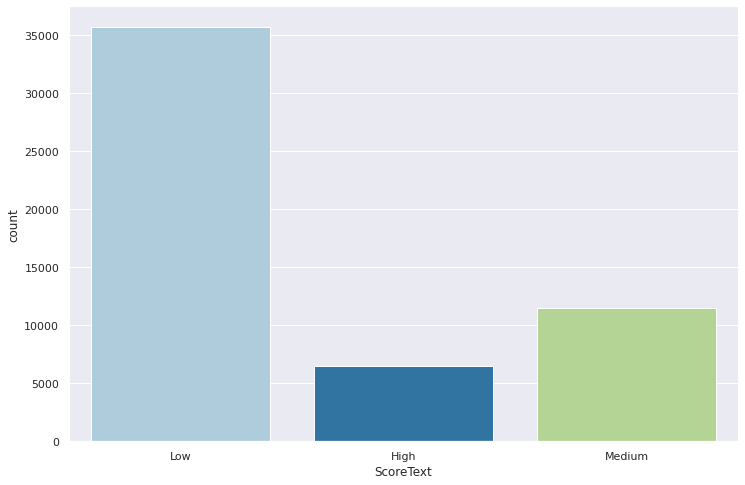

In [ ]:
sns.countplot(data=compas_df,x='ScoreText')

In [ ]:
compas_df.ScoreText.value_counts()

Low       35671
Medium    11444
High       6513
Name: ScoreText, dtype: int64

### Label Encoder

In [ ]:
le = LabelEncoder()
compas_df.Agency_Text = le.fit_transform(compas_df.Agency_Text)
compas_df.Sex_Code_Text = le.fit_transform(compas_df.Sex_Code_Text)
compas_df.Ethnic_Code_Text = le.fit_transform(compas_df.Ethnic_Code_Text)
compas_df.ScaleSet = le.fit_transform(compas_df.ScaleSet)
compas_df.Language = le.fit_transform(compas_df.Language)
compas_df.LegalStatus = le.fit_transform(compas_df.LegalStatus)
compas_df.CustodyStatus = le.fit_transform(compas_df.CustodyStatus)
compas_df.MaritalStatus = le.fit_transform(compas_df.MaritalStatus)
compas_df.DisplayText = le.fit_transform(compas_df.DisplayText)
compas_df.ScoreText = le.fit_transform(compas_df.ScoreText)
compas_df.AssessmentType = le.fit_transform(compas_df.AssessmentType)

### Test Train Split

In [ ]:
X = compas_df.drop('ScoreText',axis=1)
y = compas_df[['ScoreText']]

K-Fold

In [ ]:
KF = StratifiedKFold(n_splits=3,shuffle=True,random_state=64)
for train_index, test_index in KF.split(X, y):
    x_train, x_test = X.iloc[list(train_index)], X.iloc[list(test_index)]
    y_train, y_test = y.iloc[list(train_index)], y.iloc[list(test_index)]

In [ ]:
print("Train data shape:{}".format(x_train.shape))
print("Test data shape:{}".format(x_test.shape))

Train data shape:(35752, 11)
Test data shape:(17876, 11)


Scaling data

In [ ]:
scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(x_train)
scaled_test = scaler.transform(x_test)

In [ ]:
x_train.head()

,Agency_Text,Sex_Code_Text,Ethnic_Code_Text,ScaleSet,Language,LegalStatus,CustodyStatus,MaritalStatus,DisplayText,AssessmentType,Age
0,2,1,2,1,0,4,0,4,2,1,24
2,2,1,2,1,0,4,0,4,0,1,24
4,2,1,2,1,0,4,0,1,1,1,32
5,2,1,2,1,0,4,0,1,0,1,32
6,2,1,0,1,0,4,0,4,2,1,22


## Decision Tree Model

In [ ]:
dt = DecisionTreeClassifier()

In [ ]:
dt.fit(scaled_train,y_train)

DecisionTreeClassifier()

In [ ]:
pred = dt.predict(scaled_test)

In [ ]:
accuracy_score(y_test,pred)

0.6628999776236294

In [ ]:
param_grid = {'criterion': ['gini', 'entropy'],  #scoring methodology; two supported formulas for calculating information gain - default is gini
              'splitter': ['best', 'random'], #splitting methodology; two supported strategies - default is best
              'max_depth': [2,4,6,8,10,None], #max depth tree can grow; default is none
              'min_samples_split': [2,5,10,.03,.05], #minimum subset size BEFORE new split (fraction is % of total); default is 2
              'min_samples_leaf': [1,5,10,.03,.05], #minimum subset size AFTER new split split (fraction is % of total); default is 1
              'max_features': [None, 'auto'], #max features to consider when performing split; default none or all
              'random_state': [0] #seed or control random number generator
             }

In [ ]:
tune_model = GridSearchCV(DecisionTreeClassifier(), 
                          param_grid=param_grid, 
                          scoring = 'roc_auc',
                          cv = 5,
                          verbose=0)
tune_model.fit(scaled_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 4, 6, 8, 10, None],
                         'max_features': [None, 'auto'],
                         'min_samples_leaf': [1, 5, 10, 0.03, 0.05],
                         'min_samples_split': [2, 5, 10, 0.03, 0.05],
                         'random_state': [0], 'splitter': ['best', 'random']},
             scoring='roc_auc')

In [ ]:
print('\033[1m'+'Decision Tree Parameters:{} '.format(tune_model.best_params_))

Decision Tree Parameters:{'criterion': 'gini', 'max_depth': 2, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'random_state': 0, 'splitter': 'best'} 


In [ ]:
dt_tuned =  DecisionTreeClassifier(criterion='gini',
                                   min_samples_split=2,
                                   max_depth=2,
                                   max_features = None,
                                   min_samples_leaf=1,
                                   random_state = 0,
                                   splitter='best')

dt_tuned.fit(scaled_train,y_train)

DecisionTreeClassifier(max_depth=2, random_state=0)

In [ ]:
pred = dt_tuned.predict(scaled_test)

In [ ]:
accuracy_score(y_test,pred)

0.6651376146788991

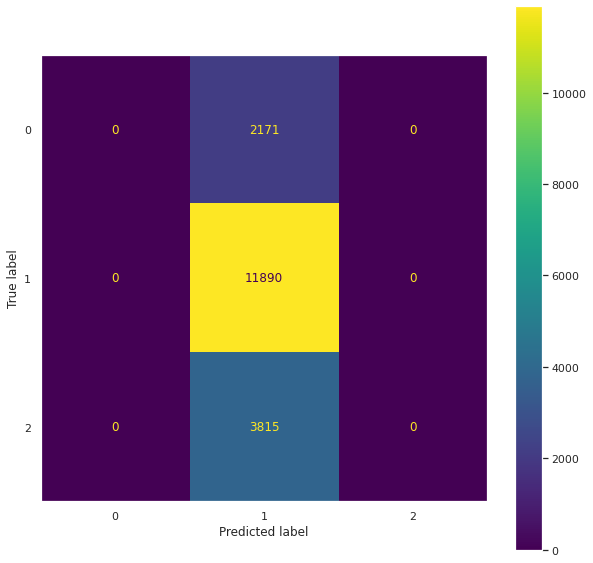

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
plt.grid(False)
plot_confusion_matrix(dt_tuned,scaled_test,y_test,ax=ax)

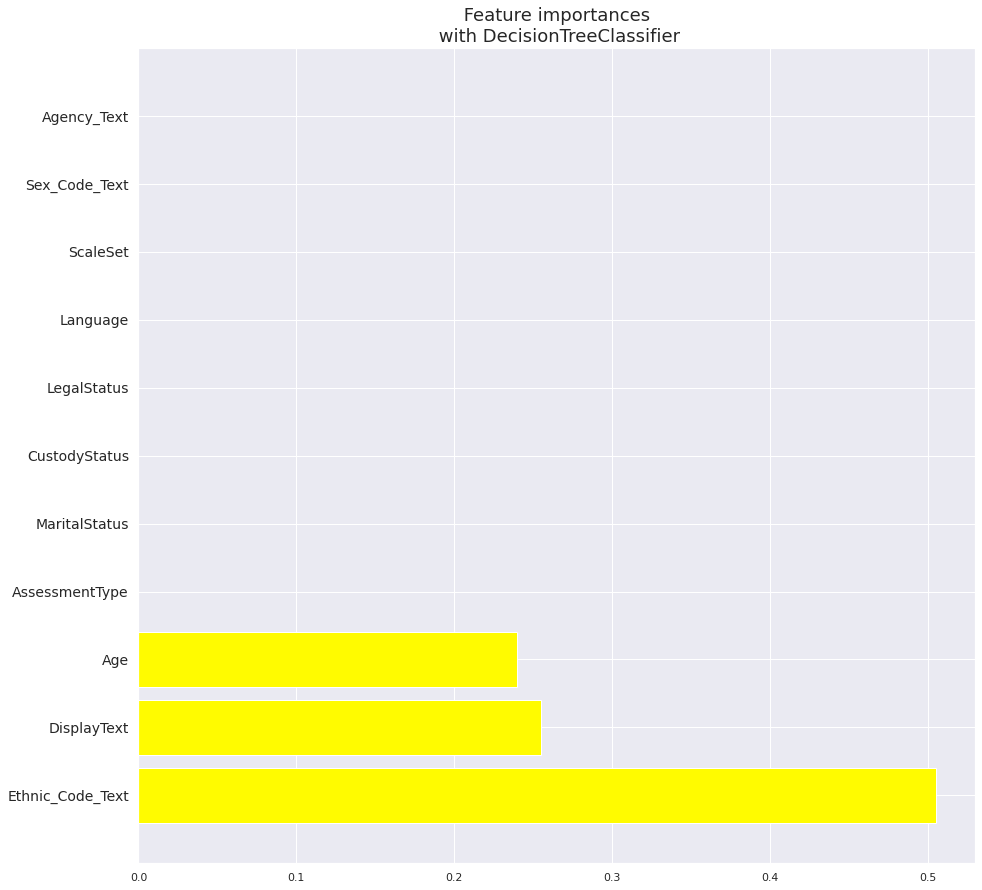

In [ ]:
tree_model = dt_tuned.fit(scaled_train, y_train)
importances = tree_model.feature_importances_
feature_names = compas_df.drop('ScoreText', axis=1).columns
indices = np.argsort(importances)[::-1]

# Plot the feature importances of the forest
def feature_importance_graph(indices, importances, feature_names):
    plt.figure(figsize=(15,15))
    plt.title(" Feature importances \n with DecisionTreeClassifier", fontsize=18)
    plt.barh(range(len(indices)), importances[indices], color='#fffb00',  align="center")
    plt.yticks(range(len(indices)), feature_names[indices], rotation='horizontal',fontsize=14)
    plt.ylim([-1, len(indices)])

feature_importance_graph(indices, importances, feature_names)
plt.show()